# Regression models with airline passengers time series

**This session follows the exact same structure as the previous session, except that now you will difference the time series beforehand, to make the time series stationary.** 

**Train a regression model on the differenced data, however, the training and test predictions will be for the differenced data, not the actual data.**

**The implication of this is you will need to undo the differencing before forecasting.**



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [3]:
df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df['LogPassengers'] = np.log(df['Passengers'])

In [5]:
# Difference the logged passengers

df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [6]:
# Note first value missing in diffed column

df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


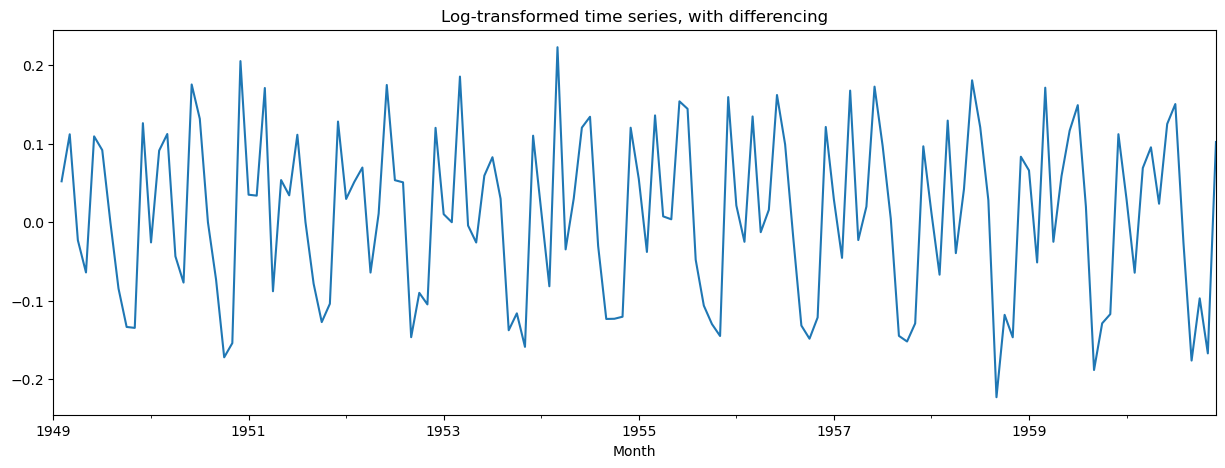

In [7]:
df['DiffLogPassengers'].plot(figsize=(15, 5))
plt.title("Log-transformed time series, with differencing");

In [8]:
# Create training and test sets

N_test = 12

train = df.iloc[: -N_test]
test = df.iloc[-N_test :]

In [9]:
# Make supervised one-step dataset - use T past values to predict the next value

# Differenced data without first value (null)
series = df['DiffLogPassengers'].to_numpy()[1:]

T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)


In [10]:
# Convert to NumPy arrays

X = np.array(X).reshape(-1, T)
Y = np.array(Y)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [11]:
# Split data into X_train, y_train, X_test, y_test

X_train, y_train = X[:-N_test], Y[:-N_test]
X_test, y_test = X[-N_test:], Y[-N_test:]

## Linear Regression model

In [12]:
lr = LinearRegression()

lr.fit(X_train, y_train)

print("Train R2 score:", lr.score(X_train, y_train))

Train R2 score: 0.6837135048453121


In [13]:
print("Test R2 score:", lr.score(X_test, y_test))

Test R2 score: 0.6492870172668166


**Notice now that the scores have worsened (worse training score and slightly worse test score).**

In [14]:
# Boolean index train and test sets against original data

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

# Initial T + 1 values are not predictable (+1 because of differencing)
train_idx[:T + 1] = False 

In [15]:
# Compute un-differenced predictions by shifting logged passengers up by one (previous value)

df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)

prev = df['ShiftLogPassengers']

In [16]:
# Obtain last-known training set value (for multi-step forecast)

last_train = train.iloc[-1]['LogPassengers']

### One-step forecast

In [17]:
# Add shifted values to predictions (only applies to 1-step forecast)

df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(X_train)

df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(X_test)

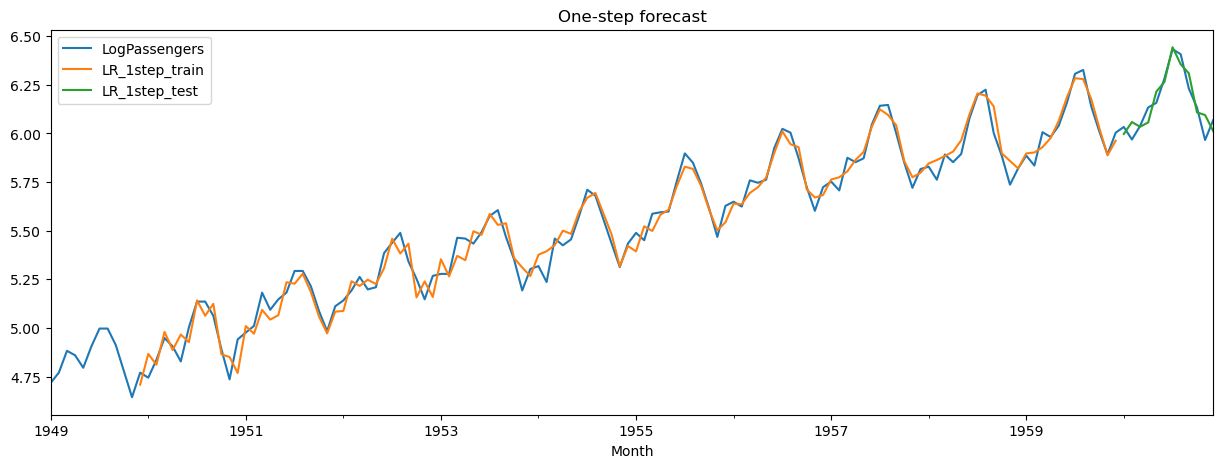

In [18]:
# Plot 1-step forecast

df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5))
plt.title("One-step forecast");

**The results look much better than before - the predictions have no problems reaching the peaks this time.**

### Incremental Multi-step forecast

**The loop to make the incremental predictions is the same as before, which returns the deltas, but this time, you need to take the last-known value from the training set and add it to the cumulative sum of the deltas.**

In [19]:
multistep_predictions = []

# Obtain first test input
last_x = X_test[0]

while len(multistep_predictions) < N_test:
    p = lr.predict(last_x.reshape(1, -1))[0]
    
    # Update the predictions list
    multistep_predictions.append(p)
    
    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [20]:
# Save multi-step forecast to dataframe as last-known train value plus cumulative sum of differences

df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

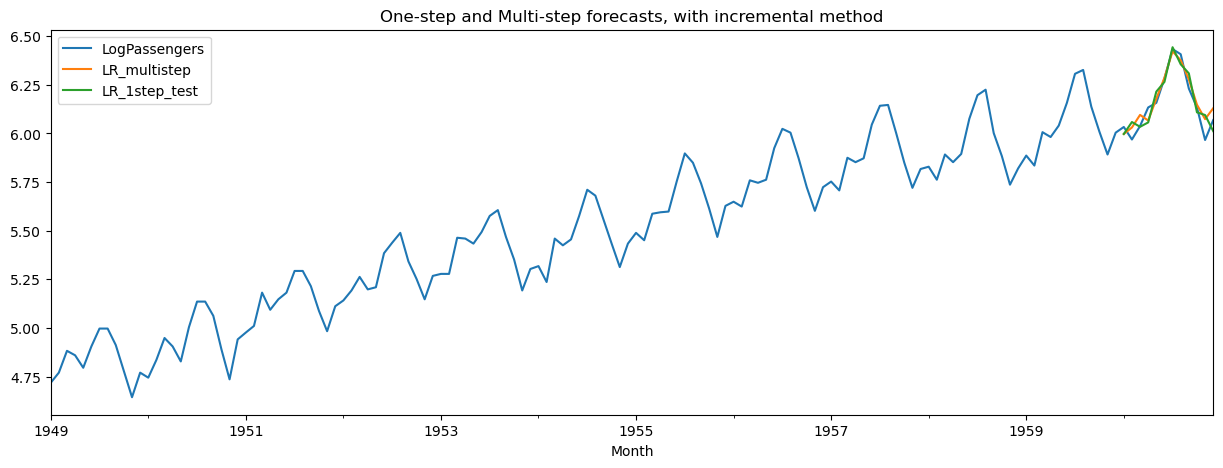

In [21]:
# Plot 1-step and multi-step forecast

df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5))
plt.title("One-step and Multi-step forecasts, with incremental method");

**The incremental multi-step predictions are also pretty good, maybe a little worse than one-step forecasts.**

### Multi-output Multi-step forecast

**With multi-output method, you need to re-create the 'supervised' dataset (same as before), so that the *Y* variable contains the predictions for the test set only.**

In [23]:
# Make multi-output supervised dataset

Tx = T
Ty = N_test
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t : t + Tx]
    X.append(x)
    y = series[t + Tx : t + Tx + Ty]
    Y.append(y)


In [24]:
# Convert to NumPy arrays

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [25]:
# Split X and Y into Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain = X[:-1], Y[:-1]

Xtest, Ytest = X[-1:], Y[-1:]

In [26]:
# Re-train model on multi-output data

lr = LinearRegression()

lr.fit(Xtrain, Ytrain)

print("Train R2 score:", lr.score(Xtrain, Ytrain))

Train R2 score: 0.8141637147930583


In [27]:
# Need to compute outside the model for test set

r2_score(lr.predict(Xtest).flatten(), Ytest.flatten())

0.7690077978619649

**The model accuracy and test accuracy has greatly improved, by at least 10%, but overall the scores are still quite low, probably due to the fact that there is not much autocorrelation between values in the time series you are trying to predict.**

In [28]:
# Save multi-output forecast to dataframe as last-known train value plus cumulative sum of differences

df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(Xtest).flatten())

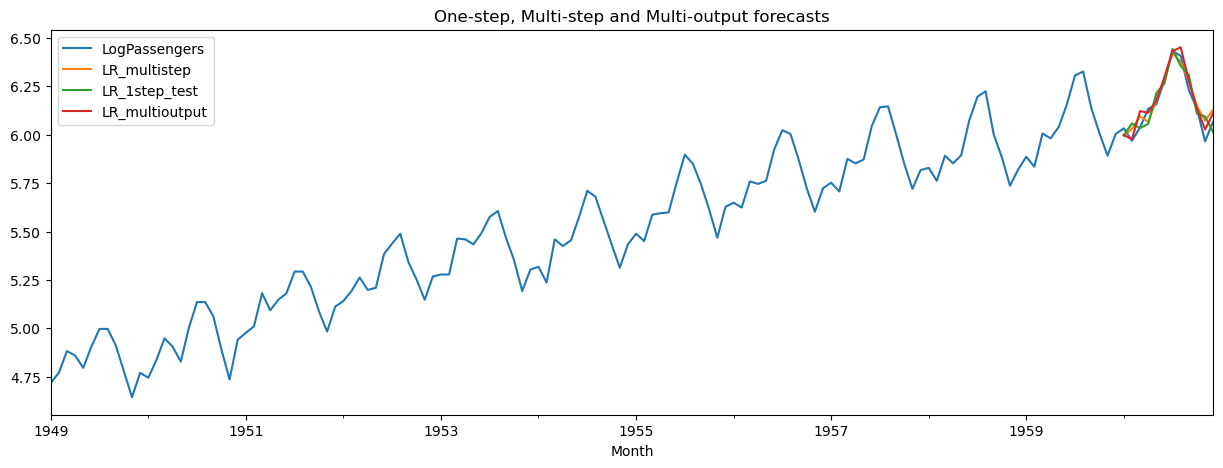

In [29]:
# Plot all forecasts
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']

df[cols].plot(figsize=(15, 5))
plt.title("One-step, Multi-step and Multi-output forecasts");

**The multi-output method forecasts seem to follow the true data more closely than the other methods, but it is hard to tell for sure. You must compute regression metrics to confirm model accuracy, e.g. `MAPE` metric.**

In [30]:
# Compute MAPE

test_log_pass = df.iloc[-N_test :]['LogPassengers']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.007109281288502526
multi-output MAPE: 0.005245261617574867


**As estimated, the multi-output method scores lower than the incremental method, making it the better choice.**

## Test other regression models

**Using the same structure as the previous session, contain all the code above into custom functions so you can quickly run the data through other regression models using one-step or multi-step forecasting.**

In [31]:
def one_step_and_multistep_forecast(model, name):
    model.fit(X_train, y_train)
    print("One-step forecast:", name)
    print("Train R^2:", model.score(X_train, y_train))
    print("Test R^2 (1-step):", model.score(X_test, y_test))
    
    # Store 1-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(X_train)
    df.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(X_test)
    
    # Generate multi-step forecast
    multistep_predictions = []
    
    # First test input
    last_x = X_test[0]
    
    while len(multistep_predictions) < N_test:
        p = model.predict(last_x.reshape(1, -1))[0]
        
        # Update the predictions list
        multistep_predictions.append(p)
        
        # Make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
        
    # Store multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)
    
    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
    print("Test MAPE (multi-step):", mape)
    
    # Plot 1-step and multi-step forecast
    cols = ['LogPassengers', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test']
    df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Train R^2: 0.6594291471853796
Test R^2 (1-step): 0.505294764564929
Test MAPE (multi-step): 0.01214912210239275


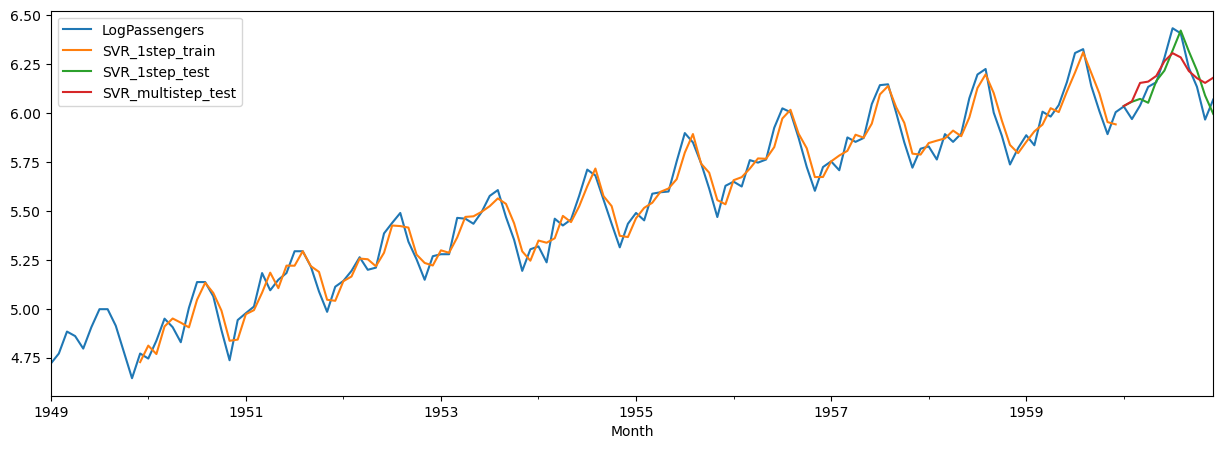

In [32]:
one_step_and_multistep_forecast(SVR(), "SVR")

**One-step and incremental multi-step forecasts score lower when using Support Vector Machine, confirmed by the plot showing that the one-step forecasts perform best if using `SVR` model.**

One-step forecast: RF
Train R^2: 0.9668733853637586
Test R^2 (1-step): 0.7195795172559332
Test MAPE (multi-step): 0.00549691522046034


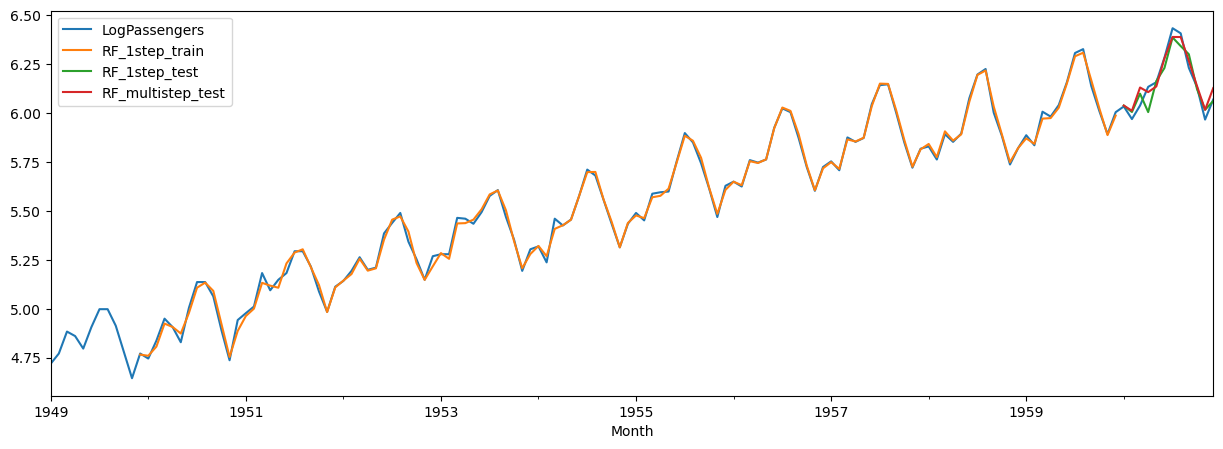

In [33]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

**For Random Forests, the model performs better, with a high training score where the training predictions match the true data almost perfectly. The test score for one-step forecast is not great, but the MAPE score is almost the same for multi-output method as Linear Regression (Linear Regression slightly better with 0.00524...).**

In [34]:
def multi_output_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    
    # Save multi-output forecast to dataframe
    df.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(model.predict(Xtest).flatten())
    
    mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
    print("Test MAPE (multi-output):", mape)
    
    # Plot all forecasts, assuming all previous functions have been run
    cols = ['LogPassengers', f'{name}_1step_train', f'{name}_1step_test', f'{name}_multistep_test', f'{name}_multioutput']
    df[cols].plot(figsize=(15, 5));

**Recall that the Support Vector Machine does not support multiple outputs, but you can create your own Suppor Vector Machine that can handle multi-outputs. This entails creating a separate SVR, one for each timestep in the forecast.**

**The `SVRWrapper` takes in the forecast horizon, and any generic optional keyword arguments, and passes it to the SVR constructor inside. Within the SVR constructor, the forecast horizon is saved and multiple SVR objects are instantiated, one for each forecast timestep. Each SVR object is fitted for each column of the target matrix. When predicting, the results from each SVR are 'stacked' horizontally.**

In [36]:
class SVRWrapper:
    def __init__(self, h, **args):
        self.h = h 
        self.models = [SVR(**args) for _ in range(h)]
        
    def fit(self, X, Y):
        for k in range(self.h):
            self.models[k].fit(X, Y[:, k])
            
    def predict(self, X):
        P = [m.predict(X) for m in self.models]
        return np.hstack(P)

Test MAPE (multi-output): 0.010731361803536803


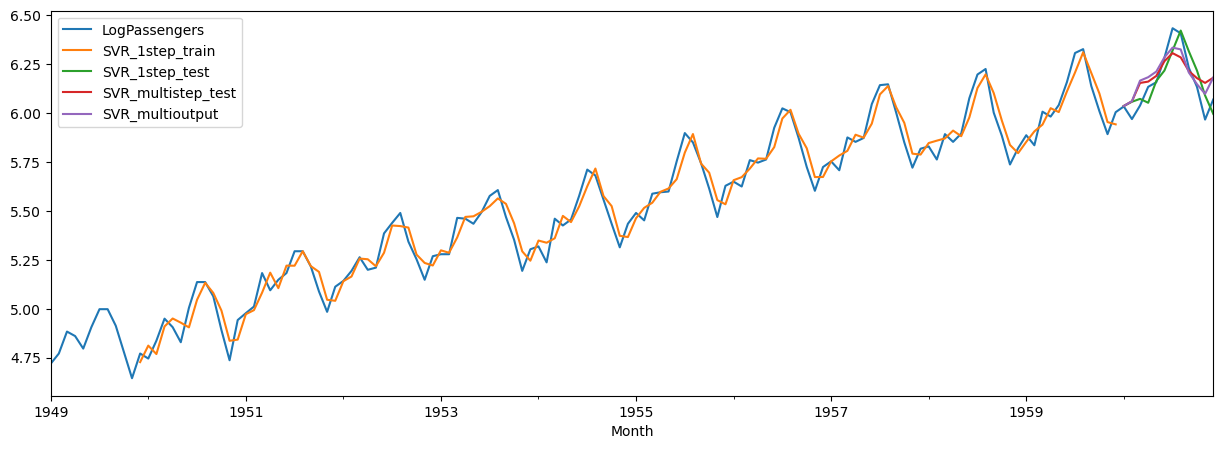

In [37]:
multi_output_forecast(SVRWrapper(N_test), "SVR")

**The multi-output method performs slightly better than the incremental method, but Support Vector Machine still does not perform that well. It may be that this is not a good model for the time series you are dealing with. Note that you can still tune the hyperparameters.**

**On the other hand, Random Forest predictions follow the true data more closely, and the low MAPE score is on par with Linear Regression model (see below).**

**Note how much better in general the models perform when using differencing.**

Test MAPE (multi-output): 0.005072693129529139


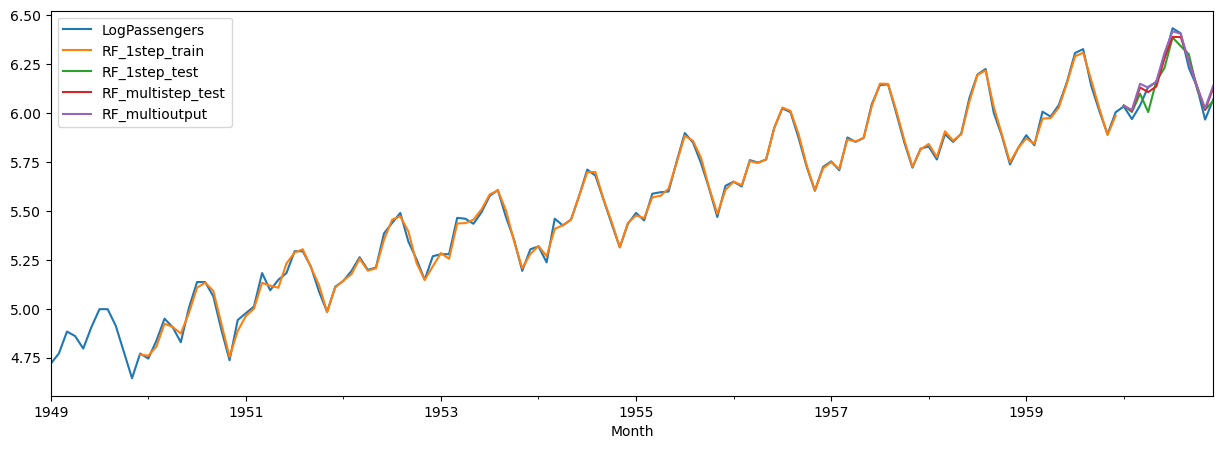

In [38]:
multi_output_forecast(RandomForestRegressor(), "RF")

**EXERCISE: Any other SciKit-Learn models you thought of trying?**